# CSCA 5642 Week 3 Assignment

## 1. Background
The data used in this assignment comes from digital pathology scans. The goal is to develop a Convolutional Neural Network model that can identify metastatic cancer. Applications like this can help patients identify potential cancer diagnoses earlier on and begin treatment.

Note: the data has been excluded from the Git repo using `.gitignore` to avoid uploading a 6GB file.

## 2. Exploratory Analysis

In [1]:
import pandas as pd
import keras
import numpy as np
from keras import layers, models, Input
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
import os
import shutil
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
import random
from PIL import Image

In [2]:
labels = pd.read_csv("histopathologic-cancer-detection/train_labels.csv")
labels

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


In [3]:
print(f"Number of samples: {len(labels):,}")
print(f"Percentage of positive samples: {len((labels[labels["label"] == 1])) / len(labels):.4f}")
print(f"Percentage of negative samples: {len((labels[labels["label"] == 0])) / len(labels):.4f}")

Number of samples: 220,025
Percentage of positive samples: 0.4050
Percentage of negative samples: 0.5950


In [4]:
def labels_split(X, y, *, val=False):
    from_path = "./histopathologic-cancer-detection/train"
    if val:
        to_path = "./histopathologic-cancer-detection/val"
    else:
        to_path = "./histopathologic-cancer-detection/train_sample"

    os.mkdir(os.path.join(to_path, "0"))
    os.mkdir(os.path.join(to_path, "1"))

    for f, label in tqdm(zip(X, y)):
        if label == 1:
            shutil.move(os.path.join(from_path, f"{f}.tif"), os.path.join(to_path, "1", f"{f}.tif"))
        elif label == 0:
            shutil.move(os.path.join(from_path, f"{f}.tif"), os.path.join(to_path, "0", f"{f}.tif"))

# os.mkdir("./histopathologic-cancer-detection/val")
# os.mkdir("./histopathologic-cancer-detection/train_sample")

# # # split into train/test first to find subset of data
X_train, X_val, y_train, y_val = train_test_split(labels["id"], labels["label"], train_size=0.01)

# # # split train set into train/val sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# labels_split(X_train.values, y_train.values)
# labels_split(X_val.values, y_val.values, val=True)

In [5]:
datagen = ImageDataGenerator(rescale=1./255)
train_datagen = datagen.flow_from_directory(
    "./histopathologic-cancer-detection/train_sample",
    class_mode="binary",
    shuffle=True,
)

val_datagen = datagen.flow_from_directory(
    "./histopathologic-cancer-detection/val",
    class_mode="binary",
    shuffle=True,
)

Found 1760 images belonging to 2 classes.
Found 440 images belonging to 2 classes.


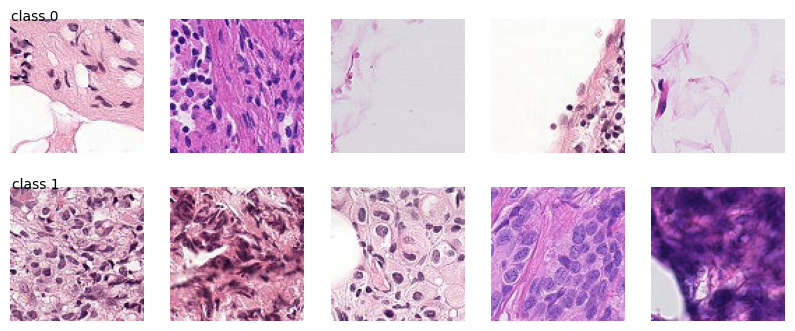

In [6]:
def visualize_samples(n_samples_per_class):
    base_dir = "./histopathologic-cancer-detection/train_sample"
    class_dirs = ["0","1"]

    fig, axes = plt.subplots(len(class_dirs), n_samples_per_class, figsize=(10, len(class_dirs)*2))
    for row, cls in enumerate(class_dirs):
        cls_path = os.path.join(base_dir, cls)
        all_files = [f for f in os.listdir(cls_path) if f.endswith(".tif")]
        picks = random.sample(all_files, n_samples_per_class)
        for col, fname in enumerate(picks):
            img = Image.open(os.path.join(cls_path, fname))
            axes[row, col].imshow(img)
            axes[row, col].axis("off")
            if col == 0:
                axes[row, col].annotate(f"class {cls}", xy=(row, col))
    plt.show()

visualize_samples(5)

## 3.Model Architecture
I am going to design a simple model (due to computing limitations) consisting of [Conv -> Conv -> MaxPool] x 2 followed by a fully connected layer. The 3 conv/pooling layers will allow for some degree (but not too much) feature extraction. The fully connected layer with a sigmoid output layer will predict whether or not the image should be flagged for cancer diagnosis. I chose SGD as my optimizer as I don't have the computing resources to use 

In [7]:
dummy = DummyClassifier(strategy="stratified")
dummy.fit(X_train, y_train)
print(f"Train accuracy score: {dummy.score(X_train, y_train):.4f}")
print(f"Validation accuracy score: {dummy.score(X_val, y_val):.4f}")

Train accuracy score: 0.5119
Validation accuracy score: 0.5364


In [8]:
def plot_loss_over_epochs(history):
    plt.figure(figsize=(7,5))
    plt.plot(range(1, history.params["epochs"]+1), history.history["loss"], label="train loss")
    plt.plot(range(1, history.params["epochs"]+1), history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.show()

In [9]:
def make_simple_cnn(learning_rate, momentum, input_shape=(256,256,3), base_filters=32):
    model = keras.Sequential([
        Input(shape=input_shape),
        layers.Conv2D(filters=base_filters, kernel_size=(3,3)),
        layers.Conv2D(filters=base_filters, kernel_size=(3,3)),
        layers.MaxPool2D(pool_size=(2,2)),
        layers.Conv2D(filters=base_filters, kernel_size=(3,3)),
        layers.Conv2D(filters=base_filters, kernel_size=(3,3)),
        layers.MaxPool2D(pool_size=(2,2)),
        layers.Conv2D(filters=base_filters, kernel_size=(3,3)),
        layers.Conv2D(filters=base_filters, kernel_size=(3,3)),
        layers.MaxPool2D(pool_size=(2,2)),
        layers.Flatten(),
        layers.Dense(units=5, activation="relu"),
        layers.Dense(units=1, activation="sigmoid"),
    ])

    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum),
        loss="binary_crossentropy",
        metrics=["accuracy", "precision", "recall"],
    )

    return model

In [10]:
def load_prep_image(path, target_size=(256,256)):
    img = image.load_img(path, target_size=target_size)
    arr = image.img_to_array(img)
    arr = arr.astype("float32") / 255.0
    return np.expand_dims(arr, 0)

def make_prediction(model, batch_size=1000):
    paths = glob.glob("./histopathologic-cancer-detection/test/*.tif")
    n_batches = (len(paths) // batch_size) + (len(paths) % batch_size != 0)

    preds = []
    for n in tqdm(range(n_batches)):
        batch = np.vstack([load_prep_image(p) for p in paths[batch_size*n:(batch_size*n)+batch_size]])
        probas = model.predict(batch)
        classes = (probas > 0.5).astype(int).flatten()
        preds.append(
            pd.DataFrame(
                {
                    "id": [os.path.splitext(os.path.basename(p))[0] for p in paths[batch_size*n:(batch_size*n)+batch_size]],
                    "label": classes
                }
            )
        )
    return pd.concat(preds)

In [11]:
EPOCHS = 5

In [12]:
model1 = make_simple_cnn(learning_rate=0.01, momentum=0.5)
model1.summary()
history1 = model1.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=EPOCHS,
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 252, 252, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 122, 122, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 61, 61, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 59, 59, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 57, 57, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │       125,445 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 172,587 (674.17 KB)

 Trainable params: 172,587 (674.17 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


/Users/jaifadia/.pyenv/versions/csca5642/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 46s 827ms/step - accuracy: 0.6098 - loss: 0.6754 - precision: 0.4015 - recall: 0.0054 - val_accuracy: 0.5750 - val_loss: 0.6634 - val_precision: 1.0000 - val_recall: 0.0053
Epoch 2/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 45s 814ms/step - accuracy: 0.6091 - loss: 0.6514 - precision: 0.2162 - recall: 0.0061 - val_accuracy: 0.5727 - val_loss: 0.6416 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 45s 813ms/step - accuracy: 0.5981 - loss: 0.6499 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5727 - val_loss: 0.6517 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 44s 806ms/step - accuracy: 0.6105 - loss: 0.6406 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5727 - val_loss: 0.6891 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 44s 801ms/step - accuracy: 0.6041 - loss: 0.6851 - precision: 0.0000e+00 - recall: 0.0000e+00

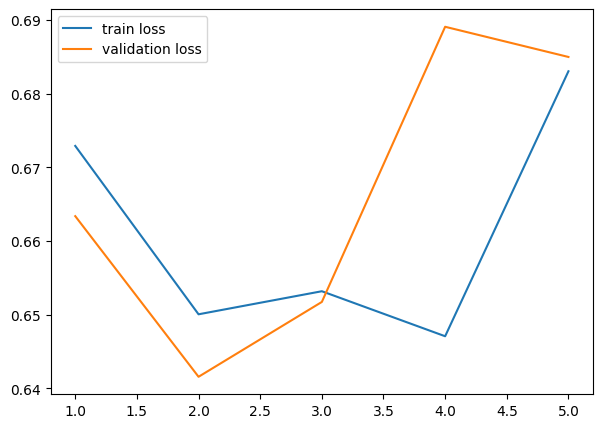

In [13]:
plot_loss_over_epochs(history1)

In [14]:
pred1 = make_prediction(model1)
pred1.to_csv("pred1.csv", index=False)

  0%|          | 0/58 [00:00<?, ?it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step


  2%|▏         | 1/58 [00:07<07:07,  7.51s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step


  3%|▎         | 2/58 [00:14<06:42,  7.19s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step


  5%|▌         | 3/58 [00:21<06:26,  7.03s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step


  7%|▋         | 4/58 [00:28<06:15,  6.95s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step


  9%|▊         | 5/58 [00:35<06:07,  6.94s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step


 10%|█         | 6/58 [00:41<05:59,  6.92s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step


 12%|█▏        | 7/58 [00:48<05:53,  6.93s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step


 14%|█▍        | 8/58 [00:55<05:47,  6.94s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step


 16%|█▌        | 9/58 [01:02<05:39,  6.93s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step


 17%|█▋        | 10/58 [01:09<05:32,  6.92s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step


 19%|█▉        | 11/58 [01:16<05:24,  6.90s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step


 21%|██        | 12/58 [01:23<05:17,  6.90s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step


 22%|██▏       | 13/58 [01:30<05:09,  6.88s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step


 24%|██▍       | 14/58 [01:37<05:03,  6.89s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step


 26%|██▌       | 15/58 [01:44<04:57,  6.91s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step


 28%|██▊       | 16/58 [01:51<04:50,  6.92s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step


 29%|██▉       | 17/58 [01:58<04:44,  6.94s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step


 31%|███       | 18/58 [02:05<04:39,  6.98s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step


 33%|███▎      | 19/58 [02:12<04:34,  7.05s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step


 34%|███▍      | 20/58 [02:19<04:28,  7.07s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step


 36%|███▌      | 21/58 [02:26<04:25,  7.18s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step


 38%|███▊      | 22/58 [02:33<04:15,  7.11s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step


 40%|███▉      | 23/58 [02:40<04:05,  7.03s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step


 41%|████▏     | 24/58 [02:47<03:55,  6.94s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step


 43%|████▎     | 25/58 [02:54<03:49,  6.94s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step


 45%|████▍     | 26/58 [03:01<03:42,  6.95s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step


 47%|████▋     | 27/58 [03:08<03:35,  6.94s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step


 48%|████▊     | 28/58 [03:15<03:28,  6.95s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step


 50%|█████     | 29/58 [03:22<03:21,  6.97s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step


 52%|█████▏    | 30/58 [03:29<03:14,  6.95s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step


 53%|█████▎    | 31/58 [03:35<03:06,  6.89s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step


 55%|█████▌    | 32/58 [03:42<02:59,  6.89s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step


 57%|█████▋    | 33/58 [03:49<02:52,  6.91s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step


 59%|█████▊    | 34/58 [03:56<02:45,  6.92s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step


 60%|██████    | 35/58 [04:03<02:38,  6.88s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step


 62%|██████▏   | 36/58 [04:10<02:31,  6.91s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step


 64%|██████▍   | 37/58 [04:17<02:25,  6.95s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step


 66%|██████▌   | 38/58 [04:24<02:20,  7.00s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step


 67%|██████▋   | 39/58 [04:31<02:13,  7.00s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step


 69%|██████▉   | 40/58 [04:38<02:05,  6.96s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step


 71%|███████   | 41/58 [04:45<01:57,  6.93s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step


 72%|███████▏  | 42/58 [04:52<01:50,  6.92s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step


 74%|███████▍  | 43/58 [04:59<01:43,  6.90s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step


 76%|███████▌  | 44/58 [05:06<01:37,  6.95s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step


 78%|███████▊  | 45/58 [05:13<01:30,  6.98s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step


 79%|███████▉  | 46/58 [05:20<01:24,  7.03s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step


 81%|████████  | 47/58 [05:27<01:17,  7.06s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step


 83%|████████▎ | 48/58 [05:34<01:10,  7.05s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step


 84%|████████▍ | 49/58 [05:41<01:03,  7.05s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step


 86%|████████▌ | 50/58 [05:48<00:56,  7.08s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step


 88%|████████▊ | 51/58 [05:55<00:49,  7.06s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step


 90%|████████▉ | 52/58 [06:02<00:42,  7.03s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step


 91%|█████████▏| 53/58 [06:09<00:35,  7.02s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step


 93%|█████████▎| 54/58 [06:16<00:28,  7.01s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step


 95%|█████████▍| 55/58 [06:23<00:21,  7.01s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step


 97%|█████████▋| 56/58 [06:30<00:13,  6.99s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step


 98%|█████████▊| 57/58 [06:37<00:06,  6.96s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step


100%|██████████| 58/58 [06:40<00:00,  6.91s/it]


In [15]:
model2 = make_simple_cnn(learning_rate=0.01, momentum=0.9)
model2.summary()
history2 = model2.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=EPOCHS,
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 252, 252, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 122, 122, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 61, 61, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 59, 59, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 57, 57, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │       125,445 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 172,587 (674.17 KB)

 Trainable params: 172,587 (674.17 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 44s 791ms/step - accuracy: 0.5596 - loss: 0.7470 - precision: 0.3730 - recall: 0.2100 - val_accuracy: 0.5727 - val_loss: 0.6828 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 43s 789ms/step - accuracy: 0.6153 - loss: 0.6711 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5727 - val_loss: 0.6841 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 44s 791ms/step - accuracy: 0.6111 - loss: 0.6684 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5727 - val_loss: 0.6855 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 44s 795ms/step - accuracy: 0.5901 - loss: 0.6779 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5727 - val_loss: 0.6855 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 44s 798ms/step - accuracy: 0.6049 - loss: 0.6712 - precision: 0.000

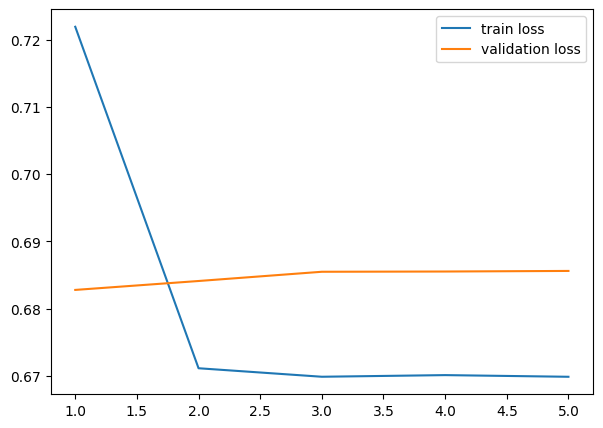

In [16]:
plot_loss_over_epochs(history2)

In [17]:
pred2 = make_prediction(model2)
pred2.to_csv("pred2.csv", index=False)

  0%|          | 0/58 [00:00<?, ?it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step


  2%|▏         | 1/58 [00:07<07:11,  7.57s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step


  3%|▎         | 2/58 [00:14<06:46,  7.25s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step


  5%|▌         | 3/58 [00:21<06:33,  7.15s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step


  7%|▋         | 4/58 [00:28<06:27,  7.18s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step


  9%|▊         | 5/58 [00:36<06:24,  7.26s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step


 10%|█         | 6/58 [00:43<06:19,  7.29s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step


 12%|█▏        | 7/58 [00:50<06:12,  7.29s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step


 14%|█▍        | 8/58 [00:58<06:03,  7.28s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 217ms/step


 16%|█▌        | 9/58 [01:06<06:06,  7.48s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step


 17%|█▋        | 10/58 [01:13<05:59,  7.48s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step


 19%|█▉        | 11/58 [01:21<05:54,  7.53s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step


 21%|██        | 12/58 [01:28<05:43,  7.47s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step


 22%|██▏       | 13/58 [01:35<05:31,  7.36s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step


 24%|██▍       | 14/58 [01:42<05:20,  7.28s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step


 26%|██▌       | 15/58 [01:49<05:09,  7.20s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step


 28%|██▊       | 16/58 [01:56<04:59,  7.12s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step


 29%|██▉       | 17/58 [02:03<04:50,  7.08s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step


 31%|███       | 18/58 [02:10<04:42,  7.07s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step


 33%|███▎      | 19/58 [02:17<04:35,  7.05s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step


 34%|███▍      | 20/58 [02:24<04:28,  7.07s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step


 36%|███▌      | 21/58 [02:31<04:20,  7.03s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step


 38%|███▊      | 22/58 [02:38<04:12,  7.02s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step


 40%|███▉      | 23/58 [02:45<04:05,  7.01s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step


 41%|████▏     | 24/58 [02:52<03:57,  7.00s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step


 43%|████▎     | 25/58 [02:59<03:51,  7.00s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step


 45%|████▍     | 26/58 [03:06<03:45,  7.06s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step


 47%|████▋     | 27/58 [03:13<03:38,  7.06s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step


 48%|████▊     | 28/58 [03:20<03:31,  7.04s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step


 50%|█████     | 29/58 [03:27<03:23,  7.02s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step


 52%|█████▏    | 30/58 [03:34<03:16,  7.02s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step


 53%|█████▎    | 31/58 [03:42<03:10,  7.06s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step


 55%|█████▌    | 32/58 [03:49<03:03,  7.05s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step


 57%|█████▋    | 33/58 [03:56<02:56,  7.05s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step


 59%|█████▊    | 34/58 [04:03<02:48,  7.03s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step


 60%|██████    | 35/58 [04:10<02:41,  7.02s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step


 62%|██████▏   | 36/58 [04:17<02:34,  7.01s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step


 64%|██████▍   | 37/58 [04:24<02:26,  7.00s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step


 66%|██████▌   | 38/58 [04:31<02:19,  6.99s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step


 67%|██████▋   | 39/58 [04:38<02:12,  6.98s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step


 69%|██████▉   | 40/58 [04:45<02:05,  6.97s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step


 71%|███████   | 41/58 [04:52<01:58,  6.98s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step


 72%|███████▏  | 42/58 [04:59<01:52,  7.01s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step


 74%|███████▍  | 43/58 [05:06<01:45,  7.03s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step


 76%|███████▌  | 44/58 [05:13<01:38,  7.04s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step


 78%|███████▊  | 45/58 [05:20<01:32,  7.10s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step


 79%|███████▉  | 46/58 [05:28<01:26,  7.23s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step


 81%|████████  | 47/58 [05:35<01:19,  7.18s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step


 83%|████████▎ | 48/58 [05:42<01:12,  7.22s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step


 84%|████████▍ | 49/58 [05:49<01:05,  7.32s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step


 86%|████████▌ | 50/58 [05:57<00:59,  7.45s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 219ms/step


 88%|████████▊ | 51/58 [06:05<00:53,  7.67s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 221ms/step


 90%|████████▉ | 52/58 [06:13<00:46,  7.77s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step


 91%|█████████▏| 53/58 [06:22<00:39,  7.96s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step


 93%|█████████▎| 54/58 [06:30<00:31,  7.95s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step


 95%|█████████▍| 55/58 [06:38<00:23,  7.90s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step


 97%|█████████▋| 56/58 [06:45<00:15,  7.81s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step


 98%|█████████▊| 57/58 [06:53<00:07,  7.71s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step


100%|██████████| 58/58 [06:56<00:00,  7.18s/it]


## 4. Results & Analysis
The main bottleneck in completing this assessment was computing resources. It was not reasonably possible to process all 200,000+ training samples and subsequently make predictions in all of the test samples. The large amount of data also limited my optimizer to SGD as I was unable to perform more complex computations using more complex optimizers.

Despite this, there are a few conclusions:

1. After a few epochs I saw a divergence in the training/validation losses, so I reduced the number of epochs to 5
2. It looks like both models are only predicting a negative outcome so the accuracy is very low
3. Having a higher momentum got the model to converge much faster